# Άσκηση 5, Τμηματοποίηση:
Θεωρήστε την εικόνα αποχρώσεων του γκρι ‘parking-lot.jpg’.

**Ζητούμενα:**
Α. Σχεδιάστε, περιγράψτε και εφαρμόστε αλγόριθμο τμηματοποίησης για την ανίχνευση των αντικειμένων που υπάρχουν στην εικόνα (για κάθε αντικείμενο προσδιορίστε ένα ξεχωριστό ορθογώνιο παραλληλεπίπεδο που να το περικλείει (bounding box)).
Β. Τυπώστε την αρχική εικόνα, προσθέτοντας (με ευδιάκριτο χρώμα) όλα τα bounding boxes που έχουν υπολογιστεί και σχολιάστε το αποτέλεσμα.

In [1]:
%pip install matplotlib numpy scikit-image --quiet

Note: you may need to restart the kernel to use updated packages.


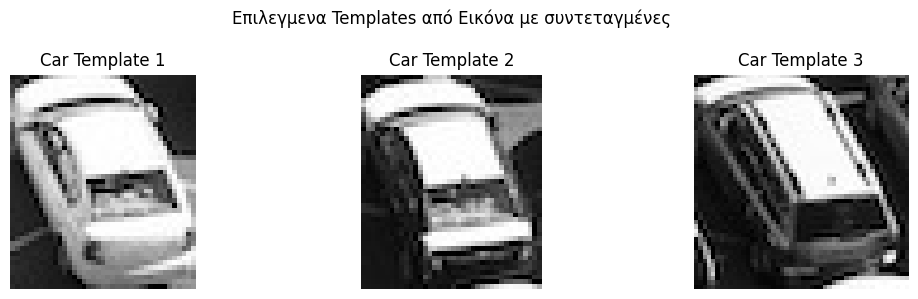

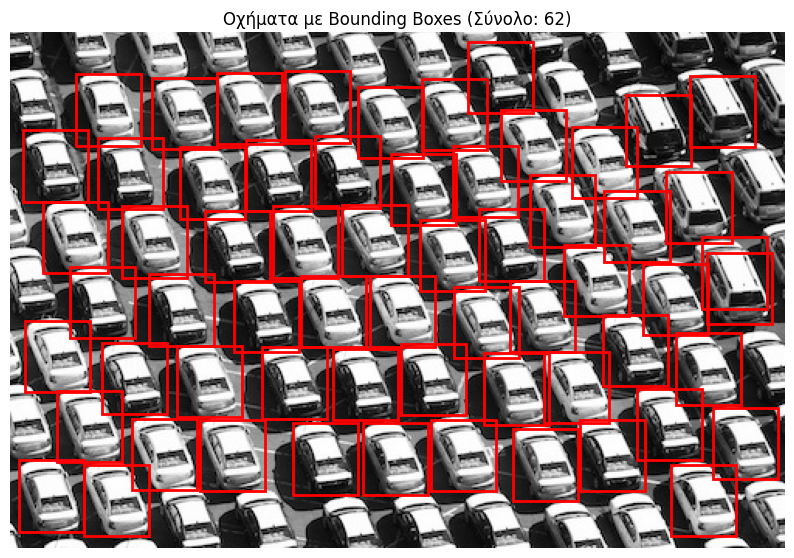

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from matplotlib.patches import Rectangle

parking_image = ski.io.imread("https://github.com/KaratziasK/DIP-Images/blob/main/images-project-1/parking-lot.jpg?raw=true")

# Συντεταγμένες των templates
car_template = [
    (233, 157, 39, 45),
    (146, 160, 38, 45),
    (431, 25, 50, 50),
]

fig, axs = plt.subplots(1, len(car_template), figsize=(11, 3))
for i, (x, y, w, h) in enumerate(car_template):
    win = parking_image[y:y+h, x:x+w]
    axs[i].imshow(win, cmap='gray')
    axs[i].set_title(f"Car Template {i+1}")
    axs[i].axis('off')
plt.suptitle("Επιλεγμενα Templates από Εικόνα με συντεταγμένες")
plt.tight_layout()
plt.show()

# Υπολογισμος του μεσου υψους και πλατους των templates
sum_h, sum_w = 0, 0
n_templates = len(car_template)
for x, y, w, h in car_template:
    sum_h += h
    sum_w += w
mean_h = int(sum_h / n_templates)
mean_w = int(sum_w / n_templates)

# Όλα τα templates το ίδιο μέγεθος
template_imgs = []
for x, y, w, h in car_template:
    temp = parking_image[y:y+h, x:x+w]
    temp_resized = ski.transform.resize(temp, (mean_h, mean_w), anti_aliasing=True)
    template_imgs.append(temp_resized)

# Πόσο ταιριάζει κάθε template σε σημεία στην εικόνας.
sim_maps = []
for tpl in template_imgs:
    sim = ski.feature.match_template(parking_image, tpl)
    sim_maps.append(sim)
sim_maps_stack = np.stack(sim_maps, axis=-1)
score_map = np.max(sim_maps_stack, axis=-1)
idx_map = np.argmax(sim_maps_stack, axis=-1)

THRESHOLD = 0.6 # ομοιότητα
MIN_DIST = 4 # απόσταση σε pixels μεταξύ των templates
boxes = ski.feature.peak_local_max(score_map, threshold_abs=THRESHOLD, min_distance=MIN_DIST)

parking_image = np.stack([parking_image]*3, axis=2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(parking_image)
ax.set_title(f"Οχήματα με Bounding Boxes (Σύνολο: {len(boxes)})")

for (y, x) in boxes:
    rect = Rectangle((x, y), mean_w, mean_h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()


# Σχόλια Αποτελέσματος:

Αρχικά προσπάθησα να χρησιμοποιήσω την μέθοδο πλημμύρας, αλλά τα αποτελέσματα δεν ηταν καλα, ισως λογω τον σκιάσεων που κάνουν τα οχήματα.
Στην εικόνα παρατηρούμε ότι πολλά οχήματα είναι ίδια μεταξύ τους, οπότε η μέθοδος σύκγρισης προτύπων είναι ιδανική. Ετσι με την βοήθεια ενός εργαλίου, εντόπισα κάποιες συντεταγμένες με τες οποίες κόβω με τον κώδικα κάποια κομάτια απο την εικόνα και τα θεωρώ ως πρότυπα.
Για κάθε template που επέλεξα, υπολόγισα το μέσο ύψος και πλάτος, ώστε όλα τα templates να έχουν ιδιο μέγεθος για τη σύγκριση με την αρχική εικόνα. Έπειτα, για κάθε template, υπολογίζω έναν χάρτη ομοιότητας που δείχνει σε ποια σημεία της εικόνας υπάρχει μεγάλη ομοιότητα με το πρότυπο. Παίρνω για κάθε pixel το μέγιστο score από όλα τα templates, για να εντοπίσω τα σημεία όπου ταιριάζει καλύτερα κάποιο από τα επιλεγμένα πρότυπα.
Στη συνέχεια, εφαρμόζω κατώφλι (threshold) στον χάρτη ομοιότητας και εντοπίζω τα τοπικά μέγιστα με τη μέθοδο peak_local_max, ώστε να βρω τις θέσεις των αντικειμένων που εντοπίζονται. Σχεδιάζω ένα bounding box στην αρχική εικόνα για τα οχήματα που εντοπίστικαν.

